Tutorial 7: Masking and Positions
=================================

We've learnt nearly all the tools we need to model strong lenses, so I'm now going to quickly cover how you should
choose your mask. I'll also show you another neat trick to improve the speed and accuracy of your non-linear search.

In [1]:
%matplotlib inline

from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

conf.instance = conf.Config(
    config_path=f"{workspace_path}/howtolens/config",
    output_path=f"{workspace_path}/howtolens/output",
)


Workspace Path:  /home/carlos/autolens_workspace


We’ll use the same strong lensing data as tutorials 1 & 2, where:

    The lens galaxy’s MassProfile is a SphericalIsothermal.
    The source galaxy’s LightProfile is a SphericalExponential.


In [2]:
from howtolens.simulators.chapter_2 import lens_sis__source_exp

dataset_type = "chapter_2"
dataset_name = "lens_sis__source_exp"
dataset_path = f"{workspace_path}/howtolens/dataset/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)

When it comes to determining an appropriate mask for this image, the best approach is to set up a Mask and pass it to a Imaging plotter. You can then check visually if the mask is an appropriate size or not.

Below, we choose an inner radius that cuts into our lensed source galaxy - clearly this isn’t a good mask.

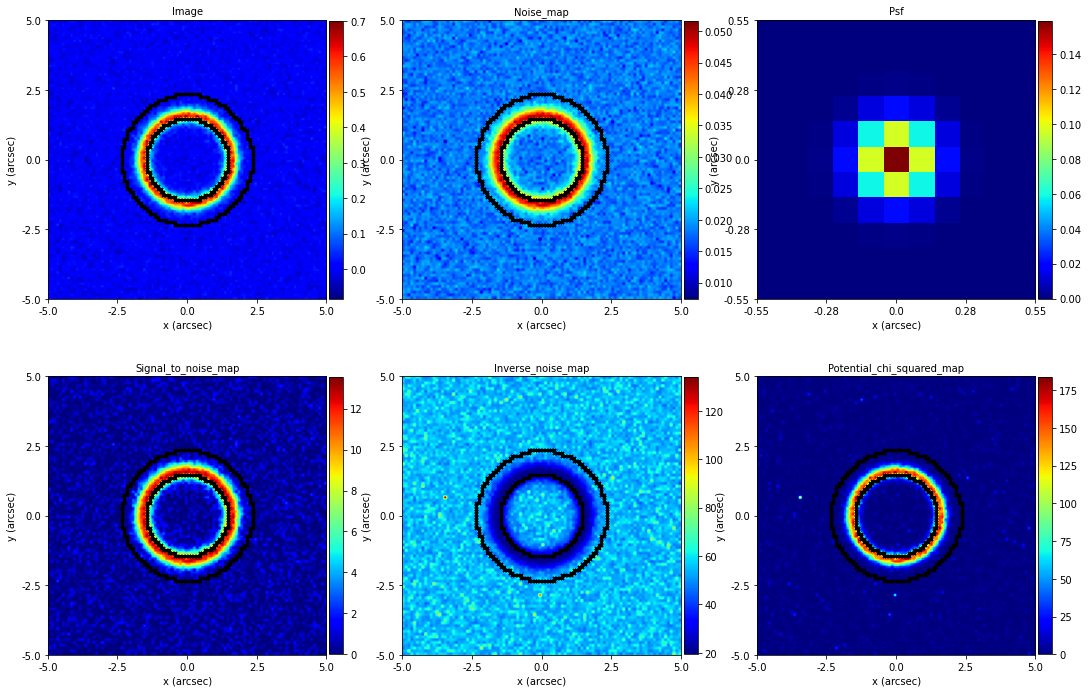

In [3]:
mask = al.Mask.circular_annular(
    shape_2d=imaging.shape_2d,
    pixel_scales=imaging.pixel_scales,
    inner_radius=1.4,
    outer_radius=2.4,
)

aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

So, lets decrease the inner radius to correct for this.

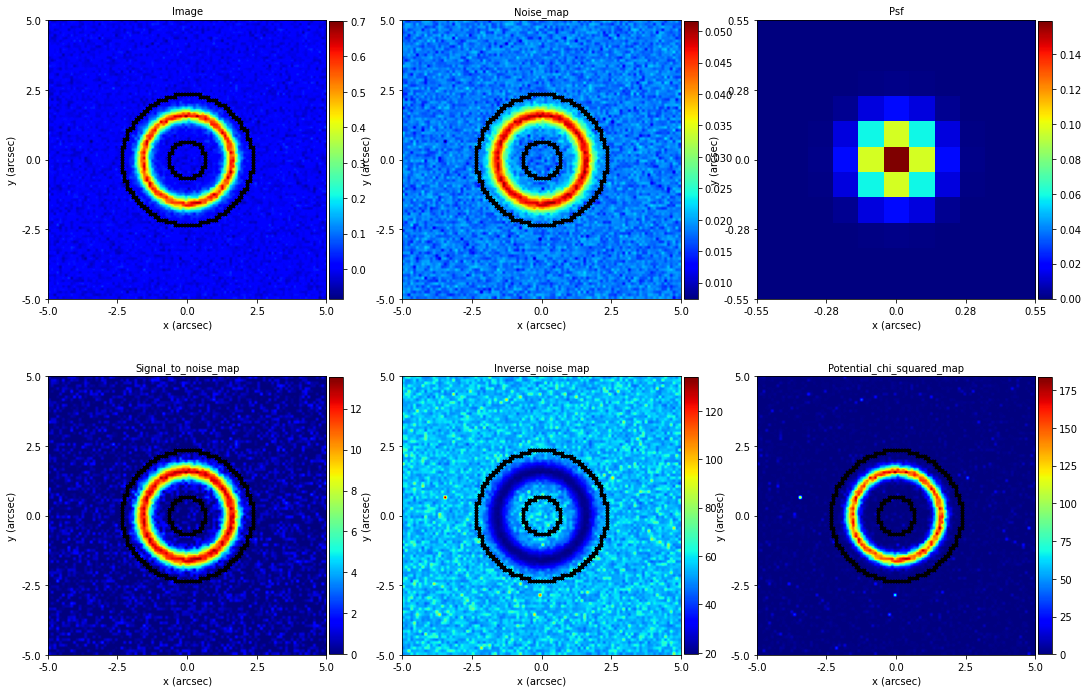

In [4]:
mask = al.Mask.circular_annular(
    shape_2d=imaging.shape_2d,
    pixel_scales=imaging.pixel_scales,
    inner_radius=0.6,
    outer_radius=2.4,
)

aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

Like in the previous tutorial, we use a_PhaseSettingsImaging_ object to specify our model-fitting procedure uses a regular Grid.

In [5]:
settings = al.PhaseSettingsImaging(grid_class=al.Grid, sub_size=2)

Now we create our phase as usual, remember that we pass the mask to the run function!

In [6]:
phase_with_custom_mask = al.PhaseImaging(
    phase_name="phase_t7_with_custom_mask",
    settings=settings,
    galaxies=dict(
        lens=al.GalaxyModel(redshift=0.5, mass=al.mp.SphericalIsothermal),
        source=al.GalaxyModel(redshift=1.0, light=al.lp.SphericalExponential),
    ),
    search=af.DynestyStatic(n_live_points=40),
)

# phase_with_custom_mask.run(dataset=imaging, mask=mask)

So, our mask encompasses the lensed source galaxy. However, is this really the right sized mask? Do we want a bigger mask? a smaller mask?

When it comes to masking, we are essentially balancing run-speed and accuracy. If speed wasn’t a consideration, bigger masks would always be better, for two reasons:

    The lensed source galaxy may have very faint emission that when you look at the plot above you don’t notice. Overly aggressive masking risks you masking out some of that light, data which would better constrain your lens model!
    When you fit an image with a model image the fit is performed only within the masked region. Outside of the masked region it is possible that the model image produces some source-galaxy light in a region of the image where it isn’t actually observed. If this region is masked, the poor fit in this region won’t reduce the model’s log likelihood.

As you use PyAutoLens more you will get a feel for how fast an analysis will run given a certain image resolution, lens model complexity, non-linear search priors / setup, etc. As you develop this intuition, I would recommend you always aim to use masks as big as possible which still give a reasonable run-speed. Aggressive masking will get your code running fast - but it could lead you to infer an incorrect lens model!

If you are fitting the foreground lens galaxy’s light you pretty much have no choice but to use a large circular mask anyway, as you’ll need to capture the lens’s extended emission. Chances are this will encompass the entire source galaxy.

We can also manually specify a set of image-pixels correspondin to the multiple images of the source-galaxy(s). During the analysis, PyAutoLens will first check that these pixels trace within a specified arc-second threshold of one another (which is controlled by the ‘position_threshold’ parameter input into a phase). This provides two benefits:

    The analysis runs faster as the non-linear search avoids searching regions of parameter space where the mass-model is clearly not accurate.
    By removing these solutions, a global-maximum solution may be reached instead of a local-maxima. This is because removing the incorrect mass models makes the non-linear parameter space less complex.

We can easily check the image-positions are accurate by plotting them using our Imaging Plotter (they are the magenta dots on the image).

To specify these positions, we use the GridCoordinates object, which is used by PyAutoLens in general to specify (y,x) coordinates.

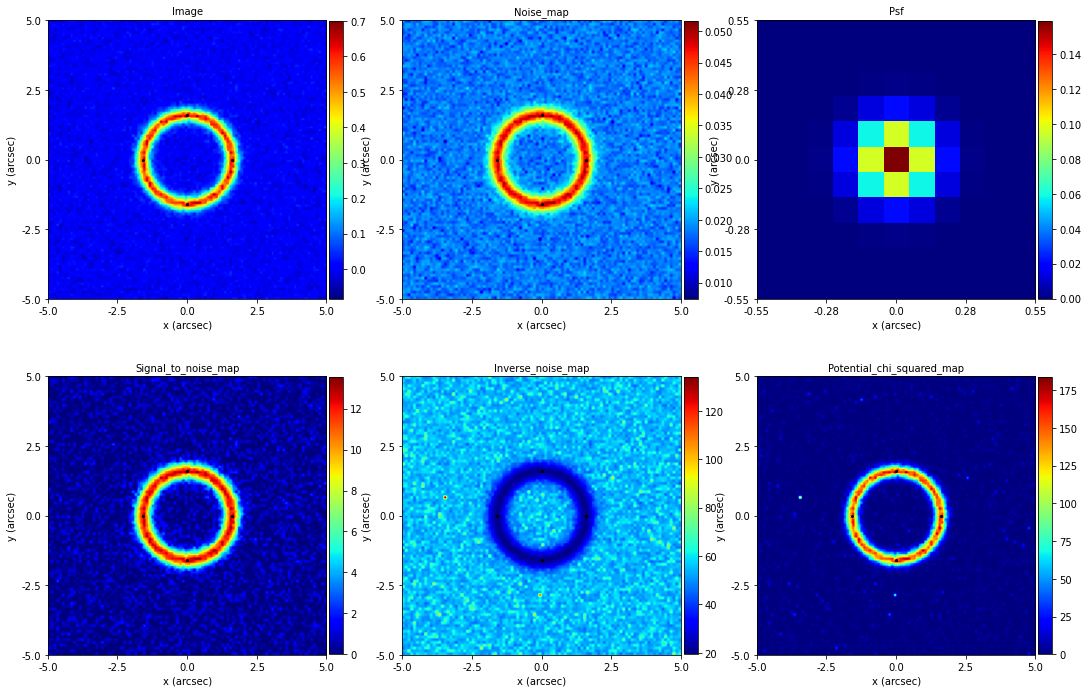

In [9]:
positions = al.GridCoordinates(
    coordinates=[(1.6, 0.0), (0.0, 1.6), (-1.6, 0.0), (0.0, -1.6)]
)

aplt.Imaging.subplot_imaging(imaging=imaging, positions=positions)

For the positions to be used in a Phase, we associate them with the Imaging data and input a ‘position_threshold’ to the PhaseSettings:

In [10]:
imaging = al.Imaging(
    image=imaging.image,
    noise_map=imaging.noise_map,
    psf=imaging.psf,
    positions=positions,
)

settings = al.PhaseSettingsImaging(
    grid_class=al.Grid, sub_size=2, positions_threshold=2.0
)

We can then tell our phase to use these positions in the analysis

In [11]:
phase_with_positions = al.PhaseImaging(
    phase_name="phase_t7_with_positions",
    settings=settings,
    galaxies=dict(
        lens=al.GalaxyModel(redshift=0.5, mass=al.mp.SphericalIsothermal),
        source=al.GalaxyModel(redshift=1.0, light=al.lp.SphericalExponential),
    ),
    search=af.DynestyStatic(n_live_points=40),
)

In [12]:
print(
    "Dynesty has begun running - checkout the workspace/output/t7_with_positions"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

phase_with_positions.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

Dynesty has begun running - checkout the workspace/output/t7_with_positions folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Dynesty samples found, beginning new non-linear search. 
141it [00:17, 11.04it/s, bound: 4 | nc: 6 | ncall: 1308 | eff(%): 10.780 | loglstar:   -inf < -19707.650 <    inf | logz: -19715.513 +/-  3.511 | dlogz: 3693.792 >  0.049]  /home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
155it [00:18, 12.64it/s, bound: 7 | nc: 5 | ncall: 1385 | eff(%): 11.191 | loglstar:   -inf < -19321.306 <    inf | logz: -19329.497 +/-  3.512 | dlogz: 3301.692 >  0.049]/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation 

Dynesty has finished run - you may now continue the notebook.


You may observe multiple source-galaxies each with their own set of multiple-images. If you have a means by which to pair different positions to the same source galaxies (for example, spectroscopic data) you can set up multiple sets of positions which each have to trace to within the position threshold of one another for the lens model to be accepted.

Lets load example data containing two distinct source galaxies.

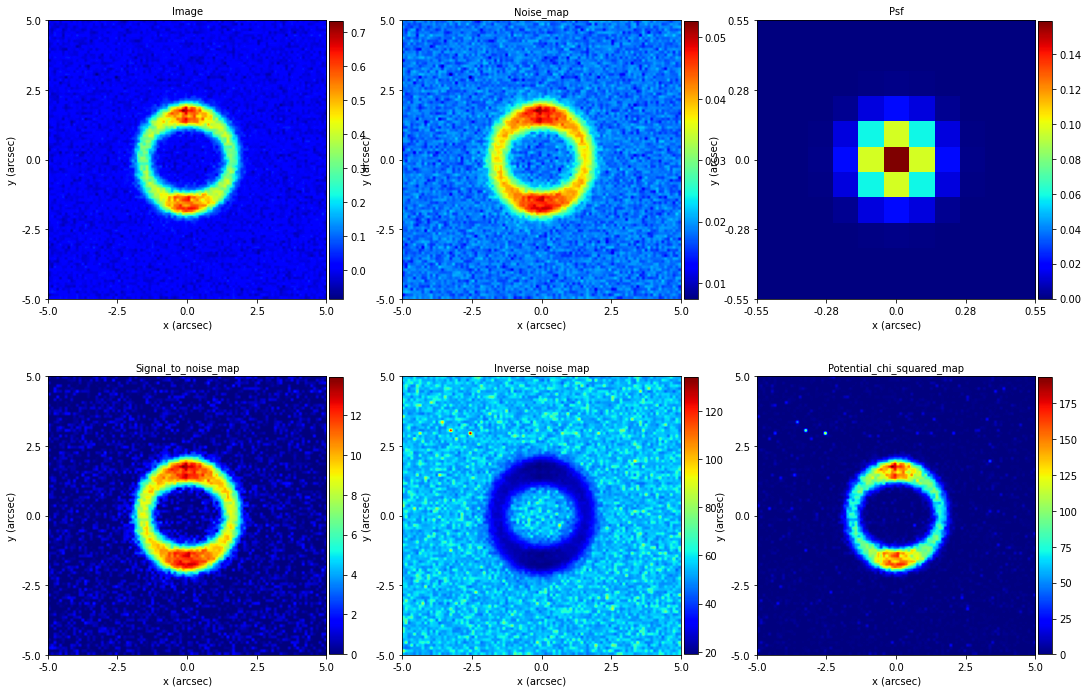

In [13]:
from howtolens.simulators.chapter_2 import lens_sis__source_exp_x2

dataset_type = "chapter_2"
dataset_name = "lens_sis__source_exp_x2"
dataset_path = f"{workspace_path}/howtolens/dataset/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)

aplt.Imaging.subplot_imaging(imaging=imaging)

To specify the positions we break the positions list into two separate lists of coordinates.

These are plotted in different colours to represent that they trace from different source galaxies.

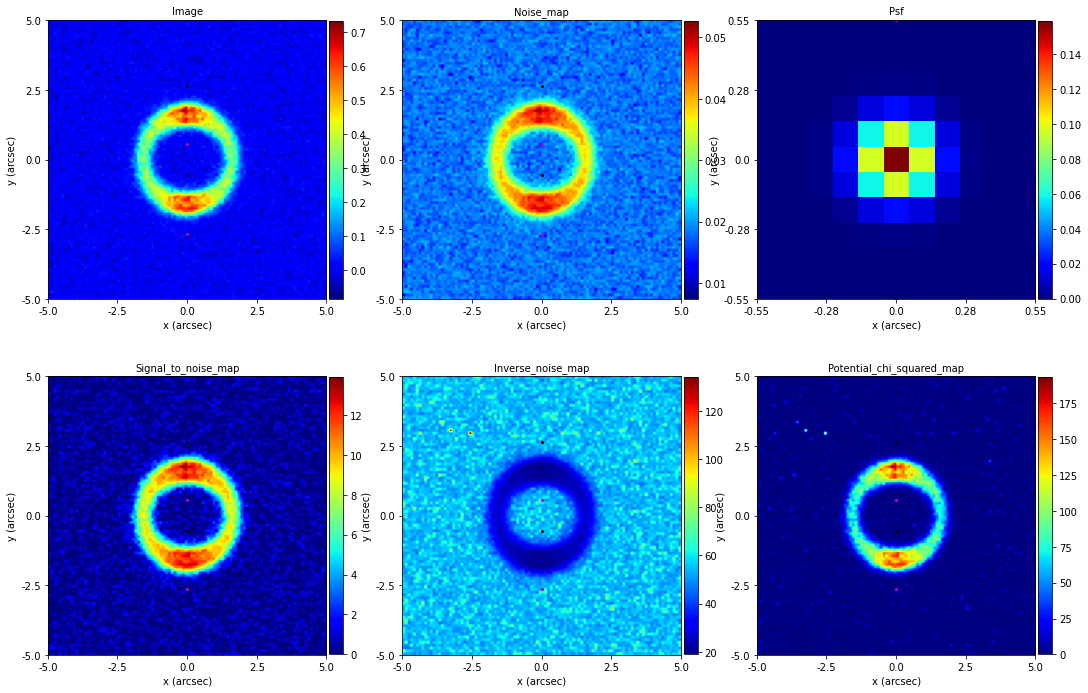

In [14]:
positions = al.GridCoordinates(
    coordinates=[[(2.65, 0.0), (-0.55, 0.0)], [(-2.65, 0.0), (0.55, 0.0)]]
)

aplt.Imaging.subplot_imaging(imaging=imaging, positions=positions)

Again, we pass the positions into our Imaging data and set a positions threshold to run the phase.

In [15]:
imaging = al.Imaging(
    image=imaging.image,
    noise_map=imaging.noise_map,
    psf=imaging.psf,
    positions=positions,
)

settings = al.PhaseSettingsImaging(
    grid_class=al.Grid, sub_size=2, positions_threshold=2.0
)

phase_with_x2_positions = al.PhaseImaging(
    phase_name="phase_t7_with_x2_positions",
    settings=settings,
    galaxies=dict(
        lens=al.GalaxyModel(redshift=0.5, mass=al.mp.SphericalIsothermal),
        source_0=al.GalaxyModel(redshift=1.0, light=al.lp.SphericalExponential),
        source_1=al.GalaxyModel(redshift=1.0, light=al.lp.SphericalExponential),
    ),
    search=af.DynestyStatic(n_live_points=40),
)

print(
    "Dynesty has begun running - checkout the workspace/output/t7_with_x2_positions"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)


phase_with_x2_positions.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

Dynesty has begun running - checkout the workspace/output/t7_with_x2_positions folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
139it [00:23,  7.31it/s, bound: 8 | nc: 6 | ncall: 1278 | eff(%): 10.876 | loglstar:   -inf < -21516.572 <    inf | logz: -21524.386 +/-  8.464 | dlogz: 3039.844 >  0.049]  /home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
232it [00:49,  4.67it/s, +40 | bound: 37 | nc: 1 | ncall: 2546 | eff(%): 10.683 | loglstar:   -inf < -11842.749 <    inf | logz: -11852.884 +/-  8.471 | dlogz:  1.099 

Dynesty has finished run - you may now continue the notebook.


And that completes our final tutorial in this chapter! At this point, I recommend that you checkout the 
'autolens_workspace/preprocess section of the workspace. This includes tools which allow you create custom masks and 
positions for a specific strong lens and output them so they can be loaded before an analysis.

When we cover pipelines next, you'll see that pipelines allow us to use a custom mask and set of positions for each 
lens we model. So, although we have to draw the masks and positions for each lens in a sample, once we've done that 
we can fit all lenses with one standardized pipeline!

 There are two things you should bare in mind in terms of masking and positions:

    1) Customizing the mask and positions for the analysis of one strong lens gets the analysis running fast and can 
       provide accurate non-linear sampling. However, for a large sample of lenses, customizing the mask and positions 
       will begin to take a lot of time. If you're willing to put that time and effort in, great, but these solutions 
       *do not* scale-up to large samples of lenses.
    
    2) A word of warning - be *extremely* careful when using positions, especially if it is unclear if the lensed 
       source galaxy has one or multiple source's of light. If your position threshold is small and the positions you 
       give the analysis correspond to different parts of the source, you may remove the *correct lens model*. In my 
       experience, as long as you keep the threshold above ~0.5" you'll be fine.

And with that, we've completed the chapter.